In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.integrate import simps
from scipy.optimize import brentq

import sys
import dill

from functools import partial
import os

In [2]:
sys.path.append('..')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

In [4]:
labelsize = 18
titlesize = 20

In [5]:
from finance.discountfactor import ConstantRateDiscountFactor

R = 0.02
H = 0.1
discount = ConstantRateDiscountFactor(R)

In [6]:
from matplotlib.ticker import FuncFormatter

formatter_tex_bps = FuncFormatter(lambda y, pos: "$%.0f$" % (10**4 * y))

def formatter_tex_time(x, pos):
    if x == 0.:
        return r'$\rm{0 \, y}$'
    
    str_x = str(x)
    
    if str_x[-1] == '0':
        return r'$\rm{%s \, y}$' % (str_x[:-2])

    return r'$\rm{%s \, y}$' % (str_x)

formatter_tex_time = FuncFormatter(formatter_tex_time)

In [7]:
LOIM_PATH = './res/aggregated/loss_over_im'
CVA_PATH = './res/aggregated/cva_ccp'

maturity = 5.

times_cva = np.arange(0, maturity, 0.5)

shifted_times_cva = times_cva + 1.
shifted_times_cva[-1] = maturity

In [8]:
def kva(q_im, q, incl_cva=False):
    disc_es = {}
    for t0, t1 in zip(times_cva, shifted_times_cva):
        str_int = '[%.2f, %.2f]' % (t0, t1)
        fname = 'loim_%s_%s.csv' % (str_int, q_im)
        loim_q_path = os.path.join(LOIM_PATH, fname)
        loim_df = pd.read_csv(loim_q_path, header=0, index_col=0)
    
        loim_ser_no_cva = loim_df.sum(axis=1)
        loim_ser = loim_ser_no_cva.copy()
        
        if incl_cva:
            fname = '%s/cva_%.2f.csv' % (q_im, t0)
            cva_q_path_t0 = os.path.join(CVA_PATH, fname)
            cva_t0_df = pd.read_csv(cva_q_path_t0, header=0, index_col=0)
        
            fname = '%s/cva_%.2f.csv' % (q_im, t1)
            cva_q_path_t1 = os.path.join(CVA_PATH, fname)
            cva_t1_df = pd.read_csv(cva_q_path_t1, header=0, index_col=0)
            
            loim_ser += discount(t1) * cva_t1_df.sum(axis=1)
            loim_ser -= discount(t0) * cva_t0_df.sum(axis=1)
        
        var = loim_ser.quantile(q, interpolation='linear')
        es_ = loim_ser[loim_ser >= var].mean() / discount(t0)
        
        disc_es[t0] = es_
        
    es = pd.Series(disc_es)
    time_grid = np.append(times_cva, maturity)
    exp_factors = np.exp(-H * time_grid)
    delta_exp_factors = np.ediff1d(exp_factors)
    es_exp = es * delta_exp_factors
    
    kva = -H / (R + H) * es_exp
    kva = kva[::-1].cumsum()[::-1]
    
    return kva

In [9]:
SHAPES = ['-s', '--^', ':o']

In [10]:
QUANTILES = [0.85, 0.955, 0.99]

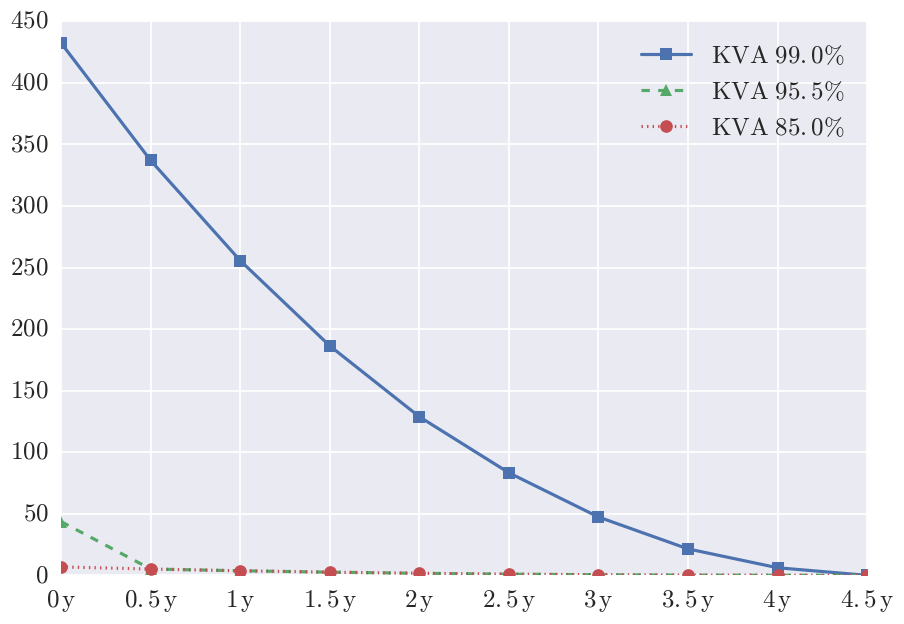

In [11]:
for q, shape in zip(QUANTILES[::-1], SHAPES):
    kva_ = kva(0.85, q)
    plt.plot(kva_.index, kva_, shape, label=r'$\rm{KVA} \, \, %s\%%$' % (q * 100))

plt.gca().xaxis.set_major_formatter(formatter_tex_time)
plt.gca().yaxis.set_major_formatter(formatter_tex_bps)

plt.legend(fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize)

plt.show()

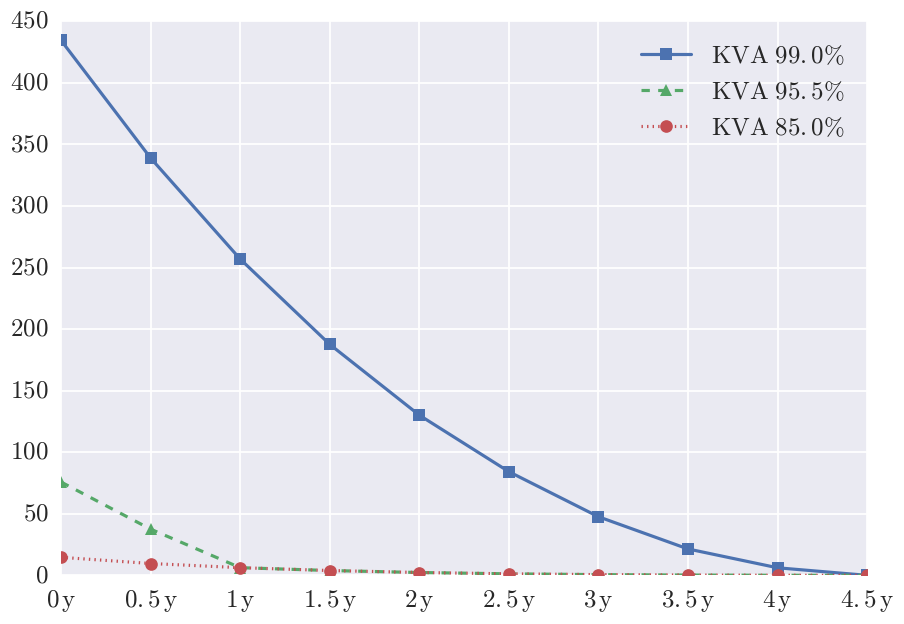

In [12]:
for q, shape in zip(QUANTILES[::-1], SHAPES):
    kva_ = kva(0.85, q, True)
    plt.plot(kva_.index, kva_, shape, label=r'$\rm{KVA} \, \, %s\%%$' % (q * 100))

plt.gca().xaxis.set_major_formatter(formatter_tex_time)
plt.gca().yaxis.set_major_formatter(formatter_tex_bps)

plt.legend(fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize)

plt.show()

In [13]:
def kva2(q_im, q, incl_cva=False):
    disc_es = {}
    for t0, t1 in zip(times_cva, shifted_times_cva):
        str_int = '[%.2f, %.2f]' % (t0, t1)
        fname = 'loim_%s_%s.csv' % (str_int, q_im)
        loim_q_path = os.path.join(LOIM_PATH, fname)
        loim_df = pd.read_csv(loim_q_path, header=0, index_col=0)
    
        loim_ser_no_cva = loim_df.sum(axis=1)
        loim_ser = loim_ser_no_cva.copy()
        
        if incl_cva:
            fname = '%s/cva_%.2f.csv' % (q_im, t0)
            cva_q_path_t0 = os.path.join(CVA_PATH, fname)
            cva_t0_df = pd.read_csv(cva_q_path_t0, header=0, index_col=0)
        
            fname = '%s/cva_%.2f.csv' % (q_im, t1)
            cva_q_path_t1 = os.path.join(CVA_PATH, fname)
            cva_t1_df = pd.read_csv(cva_q_path_t1, header=0, index_col=0)
            
            loim_ser += discount(t1) * cva_t1_df.sum(axis=1)
            loim_ser -= discount(t0) * cva_t0_df.sum(axis=1)
        
        var = loim_ser.quantile(q, interpolation='linear')
        es_ = loim_ser[loim_ser >= var].mean()
        
        disc_es[t0] = es_
        
    es = pd.Series(disc_es)
    time_grid = np.append(times_cva, maturity)
    
    exp_factors = -np.exp(-H * time_grid)
    delta_exp_factors = np.ediff1d(exp_factors)
    es_exp = es * delta_exp_factors
    
    kva = es_exp[::-1].cumsum()[::-1]
    
    return kva

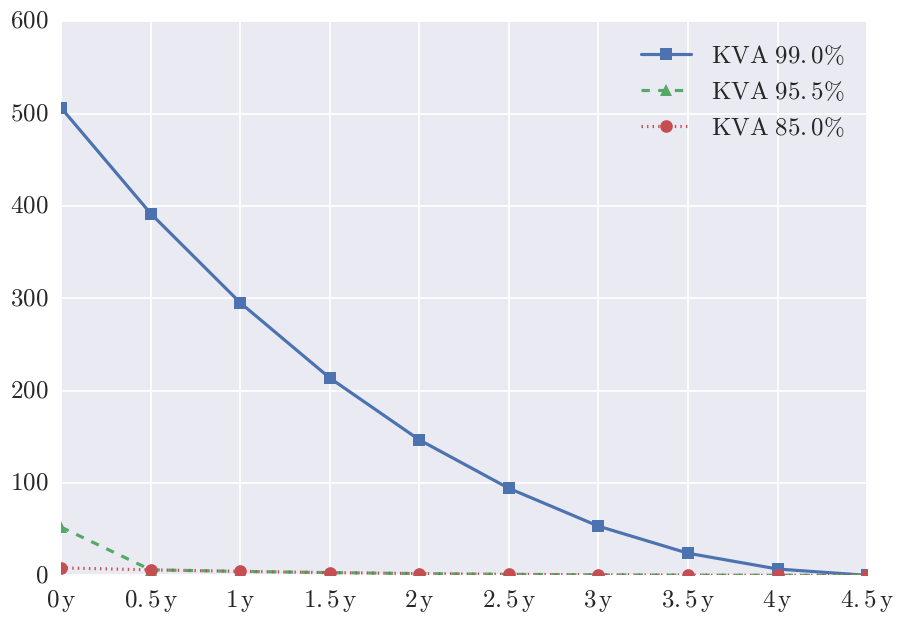

In [14]:
for q, shape in zip(QUANTILES[::-1], SHAPES):
    kva_ = kva2(0.85, q)
    plt.plot(kva_.index, kva_, shape, label=r'$\rm{KVA} \, \, %s\%%$' % (q * 100))

plt.gca().xaxis.set_major_formatter(formatter_tex_time)
plt.gca().yaxis.set_major_formatter(formatter_tex_bps)

plt.legend(fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize)

plt.show()

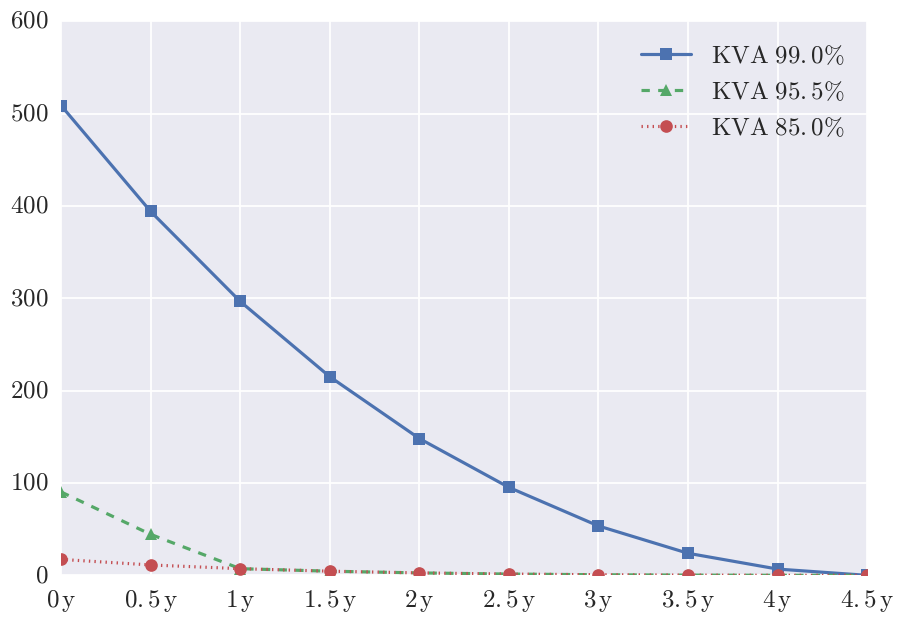

In [15]:
for q, shape in zip(QUANTILES[::-1], SHAPES):
    kva_ = kva2(0.85, q, True)
    plt.plot(kva_.index, kva_, shape, label=r'$\rm{KVA} \, \, %s\%%$' % (q * 100))

plt.gca().xaxis.set_major_formatter(formatter_tex_time)
plt.gca().yaxis.set_major_formatter(formatter_tex_bps)

plt.legend(fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize)

plt.show()